In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


In [2]:
import os
import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
import time
import json
import warnings
from datetime import timedelta
import logging
logging.getLogger('tensorflow').disabled = True

import tensorflow as tf
from utils import *
from model import *
import argparse
tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Defining some parameters

In [3]:
images_number = 10
BATCH_SIZE =  16
NUM_CLASSES = 2
rand_seed=69
assert images_number<=BATCH_SIZE, "too many images"

IMG_WIDTH, IMG_HEIGHT = 128, 128
BETA_1, BETA_2 = 0.4, 0.99
thres_int = 0.5
truncated_uniform_scale_flag = False
EPOCHS = 1

In [4]:
model_name = None
""" saving paths """
if model_name:
    output_dir = "output"
    print("[*] proceeding to load model: {}".format(model_name))
    model_dir = model_name

    image_dir = '{}/images'.format(model_dir)
    checkpoints_dir = '{}/checkpoints'.format(model_dir)
    for path in [output_dir, model_dir, image_dir, checkpoints_dir]:
        if not os.path.exists(path):
            os.mkdir(path)
else:
    checkpoints_dir = '../models/checkpoints'

In [5]:
""" tf session definitions """
tf.reset_default_graph()
tf.random.set_random_seed(rand_seed)
config = tf.ConfigProto()
if tf.test.is_gpu_available():
    print("using GPU")
    config.gpu_options.allow_growth = True
    #config.log_device_placement = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.9
else:
    print("GPU unavailable, reverting to CPU which may cause slower inference")
sess = tf.Session(config=config)

GPU unavailable, reverting to CPU which may cause slower inference


In [13]:
""" load TFRecordDataset """
validation_data = Barkley_Deep_Drive('../resources/test.tfrecords')

val_iterator = validation_data.get_batch(EPOCHS, BATCH_SIZE, shuffle = True)

val_image_iterator, val_label_iterator = val_iterator.get_next()

In [14]:
""" Placeholders """
xa = tf.placeholder(tf.float32,shape=[BATCH_SIZE,IMG_WIDTH,IMG_HEIGHT,3],name="xa") #orignal image
z = encoder(xa, reuse=tf.AUTO_REUSE) #encoder output

a = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_CLASSES],name="a") #original attributes
b = tf.placeholder(tf.float32, shape=[BATCH_SIZE, NUM_CLASSES],name="b") #desired attributes

xb_hat = decoder(z, b, reuse=tf.AUTO_REUSE, is_training=False) #decoder output
with tf.control_dependencies([xb_hat]):
    xa_hat = decoder(z, a, reuse=tf.AUTO_REUSE, is_training=False) #decoder output

xa_logit_D, xa_logit_C = classifier_and_discriminator(xa, reuse=tf.AUTO_REUSE, NUM_CLASSES = NUM_CLASSES)
xb_logit_D, xb_logit_C = classifier_and_discriminator(xb_hat, reuse=tf.AUTO_REUSE, NUM_CLASSES = NUM_CLASSES)


In [15]:
checkpoints_dir

'../models/checkpoints'

In [16]:
""" checkpoints load """
epoch_to_restore = load_checkpoint(checkpoints_dir, sess)


[*] Loading checkpoint succeeds! Copy variables from ../models/checkpoints/Epoch_119_1010.ckpt!


In [17]:
""" mapping defintions """
if NUM_CLASSES == 2:
    a_label_mapping = {'daytime': [1, 0], 'night': [0, 1]}
    b_label_mapping = {'daytime': [0, 1], 'night': [1, 0]}
else:
    label_mapping = {'daytime': [1], 'night': [0]}
    flip = {'1':[0], '0': [1] }

# Main loop

In [18]:
""" image generation """

sess.run(val_iterator.initializer)

# Generating reconstructed image xa_hat and flipped attribute image xb_hat
image_batch, label_batch = sess.run([val_image_iterator, val_label_iterator])

# Transform label batch in our simple one hot encoded version
if NUM_CLASSES == 2:
    a_label_batch = [a_label_mapping[label.decode("utf-8")] for label in label_batch]
    b_label_batch = [b_label_mapping[label.decode("utf-8")] for label in label_batch]
else:
    a_label_batch = [label_mapping[label.decode("utf-8")] for label in label_batch]
    b_label_batch = [flip[str(label[0])] for label in a_label_batch]


# Transform label batch in our simple one hot encoded version
if truncated_uniform_scale_flag:
    #TO DO: fix a_label_batch dtype from list to array
    b_label_batch = tf.random_shuffle(a_label_batch)
    a_label_batch = (tf.to_float(a_label_batch) * 2 - 1) * thres_int
    b_label_batch = (tf.to_float(b_label_batch) * 2 - 1) * (tf.truncated_normal(tf.shape(b_label_batch)) + 2) / 4.0 * (2 * thres_int)
    a_label_batch = sess.run(a_label_batch)
    b_label_batch = sess.run(b_label_batch)
else:
    a_label_batch = np.asarray(a_label_batch, dtype=np.float32)
    b_label_batch = np.asarray(b_label_batch, dtype=np.float32)

    step_xb_hat = sess.run(xb_hat, feed_dict={a:a_label_batch, b:b_label_batch, xa:image_batch})
    step_xa_hat = sess.run(xa_hat, feed_dict={a:a_label_batch, b:b_label_batch, xa:image_batch})


# images testing

100%|██████████| 10/10 [00:00<00:00, 11.85it/s]


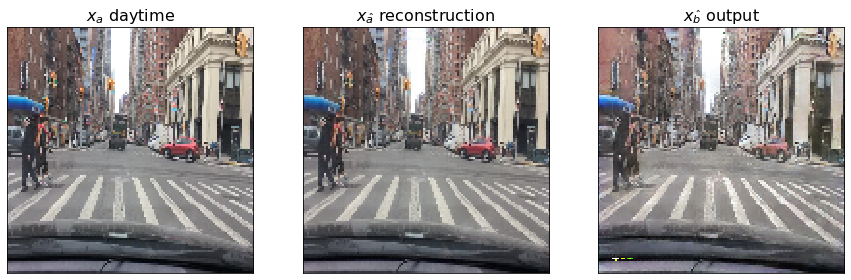

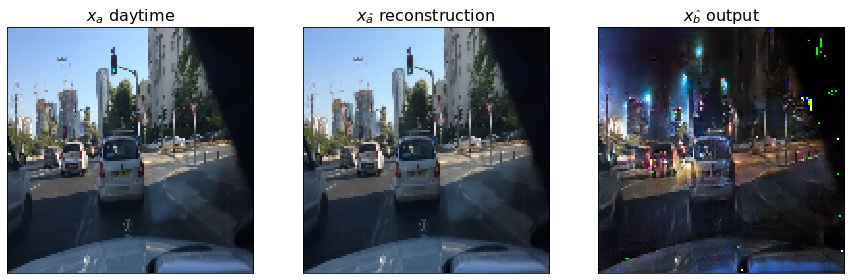

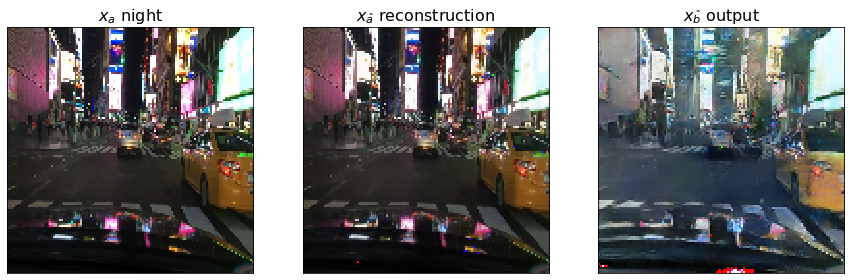

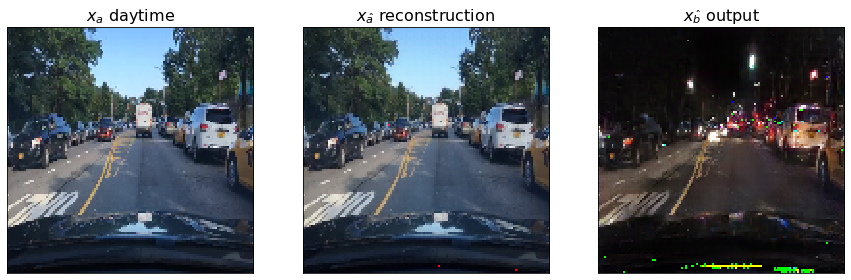

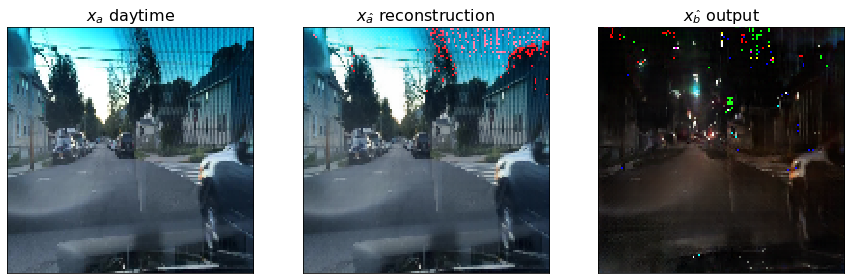

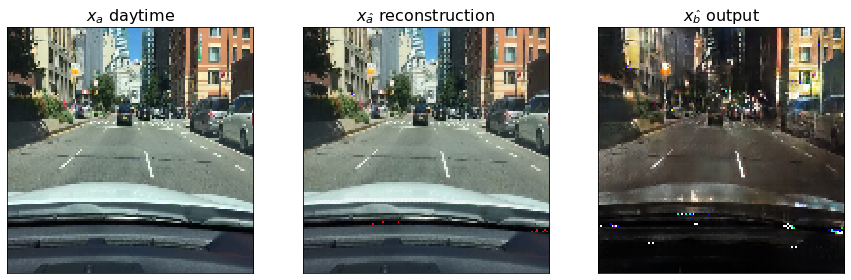

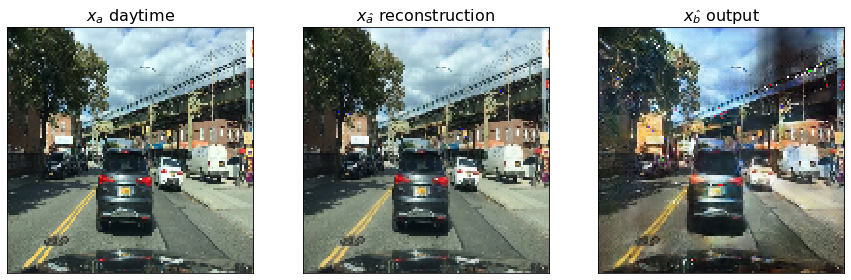

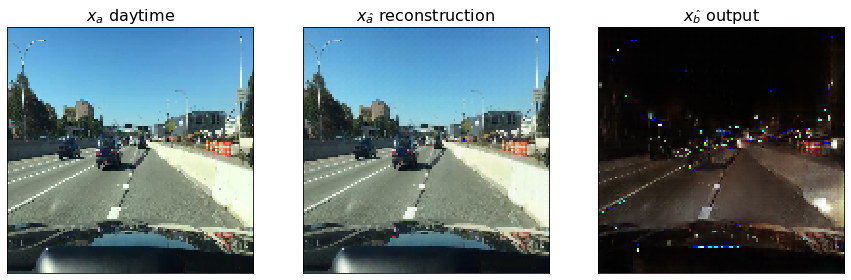

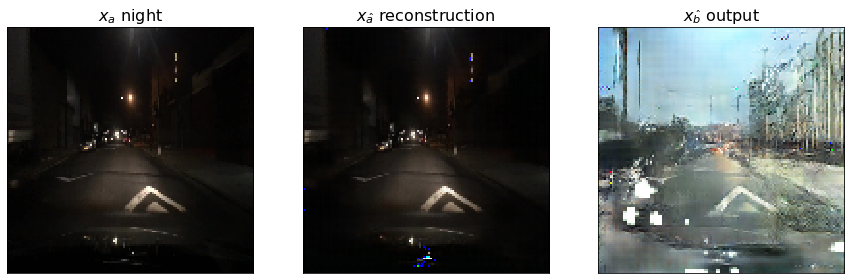

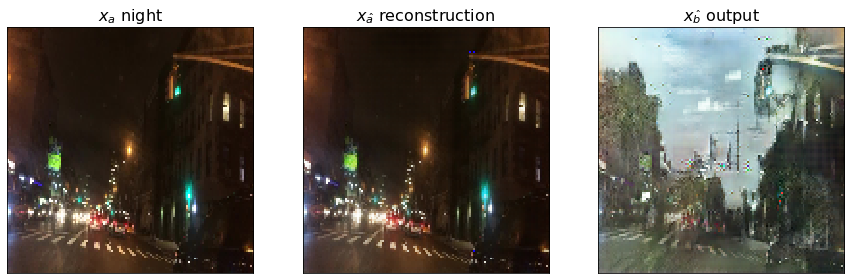

In [19]:
fontsize = 16
for i in tqdm.tqdm(range(images_number), total = images_number):
    fig, axes = plt.subplots(1,3, figsize=(15, 10))
    axes[0].set_title("$x_a$ {}".format(label_batch[i].decode("utf-8")), fontsize=fontsize)                           
    axes[0].imshow( (image_batch[i] * 255).astype(np.uint8) )
    axes[0].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    axes[1].set_title("$x_\hat{a}$ reconstruction", fontsize=fontsize)                           
    axes[1].imshow( (step_xa_hat[i] * 255).astype(np.uint8) )
    axes[1].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    axes[2].set_title("$x_\hat{b}$ output", fontsize=fontsize)    
    axes[2].imshow( (step_xb_hat[i] * 255).astype(np.uint8) )
    axes[2].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    

